# PointPillars

Changes made based on [Major bugs](https://github.com/tyagi-iiitv/PointPillars/issues/27)

## Initial Changes (V2)

### Transformation operations

Made changes to `processors.py` to correct the transformation operations

```python
@staticmethod
def transform_labels_into_lidar_coordinates(labels: List[Label3D], R: np.ndarray, t: np.ndarray):
    transformed = []
    for label in labels:
        label.centroid = (label.centroid - t) @ np.linalg.inv(R).T       # corrected 
        label.dimension = label.dimension[[2, 1, 0]] # h w l => l ,w ,h
        label.yaw = -label.yaw   # the label.yaw is in the camera frame, 
        # in the lidar frame, the yaw is negative of label.yaw
        label.yaw -= np.pi / 2
```

In order to get the correct z-center coordinate of the bounding box, the following offset was added in lidar frame

```python
 label.centroid[2] += label.dimension[2] / 2   # the height

```

### Index for bestAnchor allocation


Made changes in `/src/point_pillars.cpp` 

```c++
td::tuple<pybind11::array_t<float>, int, int> createPillarsTarget(const pybind11::array_t<float>& objectPositions,
                                             const pybind11::array_t<float>& objectDimensions,
                                             const pybind11::array_t<float>& objectYaws,
                                             const pybind11::array_t<int>& objectClassIds,
                                             const pybind11::array_t<float>& anchorDimensions,
                                             const pybind11::array_t<float>& anchorZHeights,
                                             const pybind11::array_t<float>& anchorYaws,
                                             float positiveThreshold,
                                             float negativeThreshold,
                                             int nbClasses,
                                             int downscalingFactor,
                                             float xStep,
                                             float yStep,
                                             float xMin,
                                             float xMax,
                                             float yMin,
                                             float yMax,
                                             float zMin,
                                             float zMax,
                                             bool printTime = false)
{
 ...
        float maxIou = 0;
        BoundingBox3D bestAnchor = {};
        int bestAnchorId = 0;
        int bestAnchorXId = 0; # add variable
        int bestAnchorYId = 0; # add variable

        ...


                    if (maxIou < iouOverlap)
                    {
                        maxIou = iouOverlap;
                        bestAnchor = anchorBox;
                        bestAnchorId = anchorCount;
                        bestAnchorXId = xId;
                        bestAnchorYId = yId;
                    }
       ...
     if (maxIou < positiveThreshold) // Comparing maxIOU for that object obtained after 
                                     // checking with every anchor box
        // If none of the anchors passed the threshold, 
        // then we place the best anchor details for that object. 
        {
            negCnt++;

            const auto xId = bestAnchorXId;
            const auto yId = bestAnchorYId;
            ...
      }
       ...

```

#### IMPORTANT: The c++ code must be recompiled after each change. So re-run `python setup.py install`

### Loss function 


In `/src/point_pillars.cpp` when preparing targets in the function `createPillarsTarget`, the angle target was changed.

Old version:
```c++
tensor.mutable_at(objectCount, xId, yId, bestAnchorId, 7) = std::sin(labelBox.yaw - bestAnchor.yaw);
```
New version:
```c++
tensor.mutable_at(objectCount, xId, yId, bestAnchorId, 7) = labelBox.yaw - bestAnchor.yaw;
```

Changed to an updated version of the loss function in `loss_v2.py`, where we have an updated `angle_loss()`  function that uses `add_sin_difference()`

```python
def add_sin_difference(self, y_true, y_pred, factor=1.0):
    if factor != 1.0:
        y_true = factor * y_true
        y_pred = factor * y_pred
    rad_pred_encoding = tf.math.sin(y_pred) * tf.math.cos(y_true)
    rad_tg_encoding = tf.math.cos(y_pred) * tf.math.sin(y_true)
    return rad_tg_encoding, rad_pred_encoding
    
def angle_loss(self, y_true: tf.Tensor, y_pred: tf.Tensor):
    y_true, y_pred = self.add_sin_difference(y_true, y_pred)
    loss = tf.compat.v1.losses.huber_loss(y_true, y_pred, delta=3.0, reduction="none")

    masked_loss = tf.boolean_mask(loss, self.mask)
    return self.angle_weight * tf.reduce_mean(masked_loss)

```

### Bounding box yaw

Changed to an updated version of inference utils in `inference_utils_v2.py`, where
```python
bb_yaw = -np.arcsin(np.clip(ang[value], -1, 1)) + real_anchors[i][4]
```
was changed to
```python
bb_yaw = ang[value] + real_anchors[i][4]
```
 
## Additional changes (V3)

 
Changed the yaw values in `point_pillars_test.py` from degrees to radians (lines 38, 46)

Copied the implementation of a lidar transformation function from [here](https://github.com/tjtanaa/PointPillars/blob/master/processors.py)

```python
@staticmethod
def transform_labels_into_lidar_coordinates(labels: List[Label3D], R: np.ndarray, t: np.ndarray):
    transformed = []
    for label in labels:
        # label.centroid = label.centroid @ np.linalg.inv(R).T - t # OLD
        label.centroid = (label.centroid - t) @ np.linalg.inv(R).T # CORRECTED
        label.dimension = label.dimension[[2, 1, 0]] # h w l => l ,w ,h
        label.yaw -= np.pi / 2
        while label.yaw < -np.pi:
            print("smaller than -pi")
            label.yaw += (np.pi * 2)
        while label.yaw > np.pi:
            print("larger than pi")
            label.yaw -= (np.pi * 2)
        transformed.append(label)
    return labels

```


New version of the network (`network_v2.py`) with some slight modifications. Copied from [here](https://github.com/tjtanaa/PointPillars/blob/master/network_v2.py)
- Changes to the initial pillar layers
- Added parameters to the batch normalization layers in the 2d CNN backbone
- Adjusted the kernel sizes of the transposed convolutions


*For mixed precision training, the `y_true` and `y_pred` input tensors to `focal_loss()` need to be manually cast to `tf.float32`*


## More changes (V4)

Added a `x = Dropout(0.1)(x)` layer after each VGG backbone for-loop.

In [ ]:
# ! python setup.py install

In [1]:
import os
import time
import numpy as np
from glob import glob
from config import Parameters
from network_v3 import build_point_pillar_graph
from loss_v2 import PointPillarNetworkLoss
from processors import SimpleDataGenerator
from readers import KittiDataReader
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from inference_utils_v2 import generate_bboxes_from_pred, GroundTruthGenerator, focal_loss_checker, rotational_nms


import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

physical_devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)
K.clear_session()

def enable_amp():
    mixed_precision.set_global_policy("mixed_float16")
    
print("Tensorflow version: ", tf.__version__)
print(physical_devices,"\n")
enable_amp()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/fixes.py:28: UserWarning: Module point_pillars was already imported from /usr/local/lib/python3.6/dist-packages/point_pillars-0.0.1-py3.6-linux-x86_64.egg/point_pillars.cpython-36m-x86_64-linux-gnu.so, but /tf/PythonProjects/object_detection/PointPillars is being added to sys.path
  from pkg_resources import parse_version  # type: ignore


Tensorflow version:  2.4.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] 

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2070 SUPER, compute capability 7.5


In [2]:
DATA_ROOT = "../kitti_dataset/training"  # TODO make main arg
MODEL_ROOT = "./logs"

In [3]:
params = Parameters()

In [4]:
pillar_net = build_point_pillar_graph(params)

In [5]:
# plot_model(pillar_net, show_shapes=True, dpi=100)

In [6]:
# pillar_net.load_weights(os.path.join(MODEL_ROOT, "model_v4.h5"))

In [7]:
loss = PointPillarNetworkLoss(params)

optimizer = Adam(lr=params.learning_rate, decay=params.decay_rate)

pillar_net.compile(optimizer, loss=loss.losses())

data_reader = KittiDataReader()

In [8]:
lidar_files = sorted(glob(os.path.join(DATA_ROOT, "velodyne", "*.bin")))
label_files = sorted(glob(os.path.join(DATA_ROOT, "label_2", "*.txt")))
calibration_files = sorted(glob(os.path.join(DATA_ROOT, "calib", "*.txt")))
# validation_len = int(0.3*len(label_files))
validation_len = int(0.0011*len(label_files))

In [9]:
validation_len

8

In [10]:
# training_gen = SimpleDataGenerator(
#     data_reader, 
#     params.batch_size, 
#     lidar_files[:-validation_len], 
#     label_files[:-validation_len], 
#     calibration_files[:-validation_len]
# )

# validation_gen = SimpleDataGenerator(
#     data_reader, 
#     params.batch_size, 
#     lidar_files[-validation_len:], 
#     label_files[-validation_len:], 
#     calibration_files[-validation_len:]
# )

In [11]:
training_gen = SimpleDataGenerator(
    data_reader, 
    params.batch_size, 
    lidar_files[:4], 
    label_files[:4], 
    calibration_files[:4]
)

validation_gen = SimpleDataGenerator(
    data_reader, 
    params.batch_size, 
    lidar_files[-validation_len:], 
    label_files[-validation_len:], 
    calibration_files[-validation_len:]
)

In [12]:
log_dir = MODEL_ROOT
ckpt_path = os.path.join(log_dir, "model_v4.h5")

epoch_to_decay = int(
    np.round(params.iters_to_decay/(params.batch_size*int(np.ceil(float(len(label_files)) /params.batch_size)))))

In [13]:
epoch_to_decay = int(2*epoch_to_decay)

In [14]:
callbacks = [
    ModelCheckpoint(filepath=ckpt_path, monitor='loss', save_best_only=True),
    LearningRateScheduler(
        lambda epoch, lr: lr * 0.8 if ((epoch % epoch_to_decay == 0) and (epoch != 0)) else lr, verbose=True),
    EarlyStopping(patience=20, monitor='loss'),
]

In [15]:
results = pillar_net.fit(
    training_gen,
    validation_data = validation_gen,
    steps_per_epoch=len(training_gen),
    callbacks=callbacks,
    use_multiprocessing=True,
    epochs=int(params.total_training_epochs),
    workers=8
)

Epoch 1/500

Epoch 00001: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 6.2466 - occupancy/conv2d_loss: 4.1788 - loc/reshape_loss: 0.0864 - size/reshape_loss: 0.0447 - angle/conv2d_loss: 0.2599 - heading/conv2d_loss: 0.1391 - clf/reshape_loss: 1.5377WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 12s 12s/step - loss: 6.2466 - occupancy/conv2d_loss: 4.1788 - loc/reshape_loss: 0.0864 - size/reshape_loss: 0.0447 - angle/conv2d_loss: 0.2599 - heading/conv2d_loss: 0.1391 - clf/reshape_loss: 1.5377 - val_loss: 4.1238 - val_occupancy/conv2d_loss: 2.

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 6/500

Epoch 00006: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 5.0129 - occupancy/conv2d_loss: 3.9440 - loc/reshape_loss: 0.0731 - size/reshape_loss: 0.0406 - angle/conv2d_loss: 0.2207 - heading/conv2d_loss: 0.0680 - clf/reshape_loss: 0.6664WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 4s 4s/step - loss: 5.0129 - occupancy/conv2d_loss: 3.9440 - loc/reshape_loss: 0.0731 - size/reshape_loss: 0.0406 - angle/conv2d_loss: 0.2207 - heading/conv2d_loss: 0.0680 - clf/re

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 11/500

Epoch 00011: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 3.4220 - occupancy/conv2d_loss: 3.0572 - loc/reshape_loss: 0.0372 - size/reshape_loss: 0.0308 - angle/conv2d_loss: 0.1952 - heading/conv2d_loss: 0.0294 - clf/reshape_loss: 0.0722WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 4s 4s/step - loss: 3.4220 - occupancy/conv2d_loss: 3.0572 - loc/reshape_loss: 0.0372 - size/reshape_loss: 0.0308 - angle/conv2d_loss: 0.1952 - heading/conv2d_loss: 0.0294 - clf/r

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 16/500

Epoch 00016: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 2.7251 - occupancy/conv2d_loss: 2.4100 - loc/reshape_loss: 0.0468 - size/reshape_loss: 0.0229 - angle/conv2d_loss: 0.1993 - heading/conv2d_loss: 0.0180 - clf/reshape_loss: 0.0279WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 4s 4s/step - loss: 2.7251 - occupancy/conv2d_loss: 2.4100 - loc/reshape_loss: 0.0468 - size/reshape_loss: 0.0229 - angle/conv2d_loss: 0.1993 - heading/conv2d_loss: 0.0180 - clf/r

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 21/500

Epoch 00021: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 2.3907 - occupancy/conv2d_loss: 2.1050 - loc/reshape_loss: 0.0278 - size/reshape_loss: 0.0178 - angle/conv2d_loss: 0.2143 - heading/conv2d_loss: 0.0120 - clf/reshape_loss: 0.0138WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 4s 4s/step - loss: 2.3907 - occupancy/conv2d_loss: 2.1050 - loc/reshape_loss: 0.0278 - size/reshape_loss: 0.0178 - angle/conv2d_loss: 0.2143 - heading/conv2d_loss: 0.0120 - clf/r

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 26/500

Epoch 00026: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 2.1317 - occupancy/conv2d_loss: 1.8688 - loc/reshape_loss: 0.0324 - size/reshape_loss: 0.0187 - angle/conv2d_loss: 0.1827 - heading/conv2d_loss: 0.0197 - clf/reshape_loss: 0.0094WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 4s 4s/step - loss: 2.1317 - occupancy/conv2d_loss: 1.8688 - loc/reshape_loss: 0.0324 - size/reshape_loss: 0.0187 - angle/conv2d_loss: 0.1827 - heading/conv2d_loss: 0.0197 - clf/r

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 31/500

Epoch 00031: LearningRateScheduler reducing learning rate to 0.00015999999595806003.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 1.8938 - occupancy/conv2d_loss: 1.6635 - loc/reshape_loss: 0.0275 - size/reshape_loss: 0.0161 - angle/conv2d_loss: 0.1699 - heading/conv2d_loss: 0.0102 - clf/reshape_loss: 0.0066WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 4s 4s/step - loss: 1.8938 - occupancy/conv2d_loss: 1.6635 - loc/reshape_loss: 0.0275 - size/reshape_loss: 0.0161 - angle/conv2d_loss: 0.1699 - heading/conv2d_loss: 0.0102 - clf/r

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 36/500

Epoch 00036: LearningRateScheduler reducing learning rate to 0.00015999999595806003.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 1.8281 - occupancy/conv2d_loss: 1.5633 - loc/reshape_loss: 0.0260 - size/reshape_loss: 0.0154 - angle/conv2d_loss: 0.1615 - heading/conv2d_loss: 0.0096 - clf/reshape_loss: 0.0523WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 4s 4s/step - loss: 1.8281 - occupancy/conv2d_loss: 1.5633 - loc/reshape_loss: 0.0260 - size/reshape_loss: 0.0154 - angle/conv2d_loss: 0.1615 - heading/conv2d_loss: 0.0096 - clf/r

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 41/500

Epoch 00041: LearningRateScheduler reducing learning rate to 0.00015999999595806003.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 1.7428 - occupancy/conv2d_loss: 1.5064 - loc/reshape_loss: 0.0271 - size/reshape_loss: 0.0260 - angle/conv2d_loss: 0.1715 - heading/conv2d_loss: 0.0069 - clf/reshape_loss: 0.0048WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 4s 4s/step - loss: 1.7428 - occupancy/conv2d_loss: 1.5064 - loc/reshape_loss: 0.0271 - size/reshape_loss: 0.0260 - angle/conv2d_loss: 0.1715 - heading/conv2d_loss: 0.0069 - clf/r

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 46/500

Epoch 00046: LearningRateScheduler reducing learning rate to 0.00015999999595806003.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 1.7150 - occupancy/conv2d_loss: 1.4333 - loc/reshape_loss: 0.0391 - size/reshape_loss: 0.0182 - angle/conv2d_loss: 0.2130 - heading/conv2d_loss: 0.0072 - clf/reshape_loss: 0.0041WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 4s 4s/step - loss: 1.7150 - occupancy/conv2d_loss: 1.4333 - loc/reshape_loss: 0.0391 - size/reshape_loss: 0.0182 - angle/conv2d_loss: 0.2130 - heading/conv2d_loss: 0.0072 - clf/r

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 51/500

Epoch 00051: LearningRateScheduler reducing learning rate to 0.00015999999595806003.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 1.5574 - occupancy/conv2d_loss: 1.3554 - loc/reshape_loss: 0.0256 - size/reshape_loss: 0.0161 - angle/conv2d_loss: 0.1463 - heading/conv2d_loss: 0.0060 - clf/reshape_loss: 0.0079WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 4s 4s/step - loss: 1.5574 - occupancy/conv2d_loss: 1.3554 - loc/reshape_loss: 0.0256 - size/reshape_loss: 0.0161 - angle/conv2d_loss: 0.1463 - heading/conv2d_loss: 0.0060 - clf/r

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 56/500

Epoch 00056: LearningRateScheduler reducing learning rate to 0.00015999999595806003.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 1.5253 - occupancy/conv2d_loss: 1.2749 - loc/reshape_loss: 0.0204 - size/reshape_loss: 0.0162 - angle/conv2d_loss: 0.1796 - heading/conv2d_loss: 0.0134 - clf/reshape_loss: 0.0208WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 4s 4s/step - loss: 1.5253 - occupancy/conv2d_loss: 1.2749 - loc/reshape_loss: 0.0204 - size/reshape_loss: 0.0162 - angle/conv2d_loss: 0.1796 - heading/conv2d_loss: 0.0134 - clf/r

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 61/500

Epoch 00061: LearningRateScheduler reducing learning rate to 0.00012799999967683107.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 1.4315 - occupancy/conv2d_loss: 1.1951 - loc/reshape_loss: 0.0252 - size/reshape_loss: 0.0147 - angle/conv2d_loss: 0.1495 - heading/conv2d_loss: 0.0156 - clf/reshape_loss: 0.0313WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 4s 4s/step - loss: 1.4315 - occupancy/conv2d_loss: 1.1951 - loc/reshape_loss: 0.0252 - size/reshape_loss: 0.0147 - angle/conv2d_loss: 0.1495 - heading/conv2d_loss: 0.0156 - clf/r

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 66/500

Epoch 00066: LearningRateScheduler reducing learning rate to 0.00012799999967683107.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 1.3014 - occupancy/conv2d_loss: 1.1307 - loc/reshape_loss: 0.0229 - size/reshape_loss: 0.0131 - angle/conv2d_loss: 0.1207 - heading/conv2d_loss: 0.0059 - clf/reshape_loss: 0.0082WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 4s 4s/step - loss: 1.3014 - occupancy/conv2d_loss: 1.1307 - loc/reshape_loss: 0.0229 - size/reshape_loss: 0.0131 - angle/conv2d_loss: 0.1207 - heading/conv2d_loss: 0.0059 - clf/r

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 71/500

Epoch 00071: LearningRateScheduler reducing learning rate to 0.00012799999967683107.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 1.1955 - occupancy/conv2d_loss: 1.0805 - loc/reshape_loss: 0.0189 - size/reshape_loss: 0.0094 - angle/conv2d_loss: 0.0772 - heading/conv2d_loss: 0.0048 - clf/reshape_loss: 0.0048WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 4s 4s/step - loss: 1.1955 - occupancy/conv2d_loss: 1.0805 - loc/reshape_loss: 0.0189 - size/reshape_loss: 0.0094 - angle/conv2d_loss: 0.0772 - heading/conv2d_loss: 0.0048 - clf/r

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 76/500

Epoch 00076: LearningRateScheduler reducing learning rate to 0.00012799999967683107.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 1.1517 - occupancy/conv2d_loss: 1.0317 - loc/reshape_loss: 0.0146 - size/reshape_loss: 0.0086 - angle/conv2d_loss: 0.0890 - heading/conv2d_loss: 0.0041 - clf/reshape_loss: 0.0036WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 4s 4s/step - loss: 1.1517 - occupancy/conv2d_loss: 1.0317 - loc/reshape_loss: 0.0146 - size/reshape_loss: 0.0086 - angle/conv2d_loss: 0.0890 - heading/conv2d_loss: 0.0041 - clf/r

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 81/500

Epoch 00081: LearningRateScheduler reducing learning rate to 0.00012799999967683107.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 1.1225 - occupancy/conv2d_loss: 0.9883 - loc/reshape_loss: 0.0135 - size/reshape_loss: 0.0086 - angle/conv2d_loss: 0.1051 - heading/conv2d_loss: 0.0036 - clf/reshape_loss: 0.0035WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 5s 5s/step - loss: 1.1225 - occupancy/conv2d_loss: 0.9883 - loc/reshape_loss: 0.0135 - size/reshape_loss: 0.0086 - angle/conv2d_loss: 0.1051 - heading/conv2d_loss: 0.0036 - clf/r

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 86/500

Epoch 00086: LearningRateScheduler reducing learning rate to 0.00010240000119665638.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 1.0997 - occupancy/conv2d_loss: 0.9666 - loc/reshape_loss: 0.0119 - size/reshape_loss: 0.0097 - angle/conv2d_loss: 0.1050 - heading/conv2d_loss: 0.0032 - clf/reshape_loss: 0.0033WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 4s 4s/step - loss: 1.0997 - occupancy/conv2d_loss: 0.9666 - loc/reshape_loss: 0.0119 - size/reshape_loss: 0.0097 - angle/conv2d_loss: 0.1050 - heading/conv2d_loss: 0.0032 - clf/r

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 91/500

Epoch 00091: LearningRateScheduler reducing learning rate to 0.00010240000119665638.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 1.0221 - occupancy/conv2d_loss: 0.9270 - loc/reshape_loss: 0.0099 - size/reshape_loss: 0.0064 - angle/conv2d_loss: 0.0727 - heading/conv2d_loss: 0.0032 - clf/reshape_loss: 0.0029WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 5s 5s/step - loss: 1.0221 - occupancy/conv2d_loss: 0.9270 - loc/reshape_loss: 0.0099 - size/reshape_loss: 0.0064 - angle/conv2d_loss: 0.0727 - heading/conv2d_loss: 0.0032 - clf/r

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 96/500

Epoch 00096: LearningRateScheduler reducing learning rate to 0.00010240000119665638.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 1.0015 - occupancy/conv2d_loss: 0.8997 - loc/reshape_loss: 0.0089 - size/reshape_loss: 0.0059 - angle/conv2d_loss: 0.0809 - heading/conv2d_loss: 0.0032 - clf/reshape_loss: 0.0029WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 4s 4s/step - loss: 1.0015 - occupancy/conv2d_loss: 0.8997 - loc/reshape_loss: 0.0089 - size/reshape_loss: 0.0059 - angle/conv2d_loss: 0.0809 - heading/conv2d_loss: 0.0032 - clf/r

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 101/500

Epoch 00101: LearningRateScheduler reducing learning rate to 0.00010240000119665638.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 0.9713 - occupancy/conv2d_loss: 0.8778 - loc/reshape_loss: 0.0092 - size/reshape_loss: 0.0057 - angle/conv2d_loss: 0.0726 - heading/conv2d_loss: 0.0030 - clf/reshape_loss: 0.0029WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 5s 5s/step - loss: 0.9713 - occupancy/conv2d_loss: 0.8778 - loc/reshape_loss: 0.0092 - size/reshape_loss: 0.0057 - angle/conv2d_loss: 0.0726 - heading/conv2d_loss: 0.0030 - clf/

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 106/500

Epoch 00106: LearningRateScheduler reducing learning rate to 0.00010240000119665638.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 0.9773 - occupancy/conv2d_loss: 0.8599 - loc/reshape_loss: 0.0078 - size/reshape_loss: 0.0041 - angle/conv2d_loss: 0.1009 - heading/conv2d_loss: 0.0028 - clf/reshape_loss: 0.0018WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 5s 5s/step - loss: 0.9773 - occupancy/conv2d_loss: 0.8599 - loc/reshape_loss: 0.0078 - size/reshape_loss: 0.0041 - angle/conv2d_loss: 0.1009 - heading/conv2d_loss: 0.0028 - clf/

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 111/500

Epoch 00111: LearningRateScheduler reducing learning rate to 0.00010240000119665638.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 0.9509 - occupancy/conv2d_loss: 0.8428 - loc/reshape_loss: 0.0100 - size/reshape_loss: 0.0062 - angle/conv2d_loss: 0.0874 - heading/conv2d_loss: 0.0027 - clf/reshape_loss: 0.0019WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 5s 5s/step - loss: 0.9509 - occupancy/conv2d_loss: 0.8428 - loc/reshape_loss: 0.0100 - size/reshape_loss: 0.0062 - angle/conv2d_loss: 0.0874 - heading/conv2d_loss: 0.0027 - clf/

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 116/500

Epoch 00116: LearningRateScheduler reducing learning rate to 8.191999950213358e-05.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 0.9477 - occupancy/conv2d_loss: 0.8361 - loc/reshape_loss: 0.0093 - size/reshape_loss: 0.0033 - angle/conv2d_loss: 0.0942 - heading/conv2d_loss: 0.0028 - clf/reshape_loss: 0.0020WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 4s 4s/step - loss: 0.9477 - occupancy/conv2d_loss: 0.8361 - loc/reshape_loss: 0.0093 - size/reshape_loss: 0.0033 - angle/conv2d_loss: 0.0942 - heading/conv2d_loss: 0.0028 - clf/r

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 121/500

Epoch 00121: LearningRateScheduler reducing learning rate to 8.191999950213358e-05.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 0.9822 - occupancy/conv2d_loss: 0.8273 - loc/reshape_loss: 0.0078 - size/reshape_loss: 0.0037 - angle/conv2d_loss: 0.1374 - heading/conv2d_loss: 0.0037 - clf/reshape_loss: 0.0023WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 4s 4s/step - loss: 0.9822 - occupancy/conv2d_loss: 0.8273 - loc/reshape_loss: 0.0078 - size/reshape_loss: 0.0037 - angle/conv2d_loss: 0.1374 - heading/conv2d_loss: 0.0037 - clf/r

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 126/500

Epoch 00126: LearningRateScheduler reducing learning rate to 8.191999950213358e-05.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 0.9131 - occupancy/conv2d_loss: 0.8105 - loc/reshape_loss: 0.0074 - size/reshape_loss: 0.0037 - angle/conv2d_loss: 0.0843 - heading/conv2d_loss: 0.0045 - clf/reshape_loss: 0.0027WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 4s 4s/step - loss: 0.9131 - occupancy/conv2d_loss: 0.8105 - loc/reshape_loss: 0.0074 - size/reshape_loss: 0.0037 - angle/conv2d_loss: 0.0843 - heading/conv2d_loss: 0.0045 - clf/r

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 131/500

Epoch 00131: LearningRateScheduler reducing learning rate to 8.191999950213358e-05.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 0.8928 - occupancy/conv2d_loss: 0.7998 - loc/reshape_loss: 0.0080 - size/reshape_loss: 0.0052 - angle/conv2d_loss: 0.0726 - heading/conv2d_loss: 0.0044 - clf/reshape_loss: 0.0027WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 4s 4s/step - loss: 0.8928 - occupancy/conv2d_loss: 0.7998 - loc/reshape_loss: 0.0080 - size/reshape_loss: 0.0052 - angle/conv2d_loss: 0.0726 - heading/conv2d_loss: 0.0044 - clf/r

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 136/500

Epoch 00136: LearningRateScheduler reducing learning rate to 8.191999950213358e-05.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 0.8552 - occupancy/conv2d_loss: 0.7867 - loc/reshape_loss: 0.0068 - size/reshape_loss: 0.0043 - angle/conv2d_loss: 0.0515 - heading/conv2d_loss: 0.0032 - clf/reshape_loss: 0.0027WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 4s 4s/step - loss: 0.8552 - occupancy/conv2d_loss: 0.7867 - loc/reshape_loss: 0.0068 - size/reshape_loss: 0.0043 - angle/conv2d_loss: 0.0515 - heading/conv2d_loss: 0.0032 - clf/r

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 141/500

Epoch 00141: LearningRateScheduler reducing learning rate to 6.553599960170687e-05.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 0.8601 - occupancy/conv2d_loss: 0.7756 - loc/reshape_loss: 0.0067 - size/reshape_loss: 0.0035 - angle/conv2d_loss: 0.0689 - heading/conv2d_loss: 0.0028 - clf/reshape_loss: 0.0025WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 5s 5s/step - loss: 0.8601 - occupancy/conv2d_loss: 0.7756 - loc/reshape_loss: 0.0067 - size/reshape_loss: 0.0035 - angle/conv2d_loss: 0.0689 - heading/conv2d_loss: 0.0028 - clf/r

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 146/500

Epoch 00146: LearningRateScheduler reducing learning rate to 6.553599814651534e-05.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 0.8420 - occupancy/conv2d_loss: 0.7639 - loc/reshape_loss: 0.0055 - size/reshape_loss: 0.0030 - angle/conv2d_loss: 0.0644 - heading/conv2d_loss: 0.0027 - clf/reshape_loss: 0.0024WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 5s 5s/step - loss: 0.8420 - occupancy/conv2d_loss: 0.7639 - loc/reshape_loss: 0.0055 - size/reshape_loss: 0.0030 - angle/conv2d_loss: 0.0644 - heading/conv2d_loss: 0.0027 - clf/r

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 151/500

Epoch 00151: LearningRateScheduler reducing learning rate to 6.553599814651534e-05.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 0.8055 - occupancy/conv2d_loss: 0.7500 - loc/reshape_loss: 0.0053 - size/reshape_loss: 0.0022 - angle/conv2d_loss: 0.0434 - heading/conv2d_loss: 0.0026 - clf/reshape_loss: 0.0021WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 5s 5s/step - loss: 0.8055 - occupancy/conv2d_loss: 0.7500 - loc/reshape_loss: 0.0053 - size/reshape_loss: 0.0022 - angle/conv2d_loss: 0.0434 - heading/conv2d_loss: 0.0026 - clf/r

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 156/500

Epoch 00156: LearningRateScheduler reducing learning rate to 6.553599814651534e-05.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 0.8084 - occupancy/conv2d_loss: 0.7372 - loc/reshape_loss: 0.0040 - size/reshape_loss: 0.0017 - angle/conv2d_loss: 0.0611 - heading/conv2d_loss: 0.0025 - clf/reshape_loss: 0.0019WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 5s 5s/step - loss: 0.8084 - occupancy/conv2d_loss: 0.7372 - loc/reshape_loss: 0.0040 - size/reshape_loss: 0.0017 - angle/conv2d_loss: 0.0611 - heading/conv2d_loss: 0.0025 - clf/r

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 161/500

Epoch 00161: LearningRateScheduler reducing learning rate to 6.553599814651534e-05.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 0.7862 - occupancy/conv2d_loss: 0.7273 - loc/reshape_loss: 0.0034 - size/reshape_loss: 0.0018 - angle/conv2d_loss: 0.0496 - heading/conv2d_loss: 0.0024 - clf/reshape_loss: 0.0017WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 5s 5s/step - loss: 0.7862 - occupancy/conv2d_loss: 0.7273 - loc/reshape_loss: 0.0034 - size/reshape_loss: 0.0018 - angle/conv2d_loss: 0.0496 - heading/conv2d_loss: 0.0024 - clf/r

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 166/500

Epoch 00166: LearningRateScheduler reducing learning rate to 6.553599814651534e-05.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 0.8036 - occupancy/conv2d_loss: 0.7166 - loc/reshape_loss: 0.0037 - size/reshape_loss: 0.0021 - angle/conv2d_loss: 0.0772 - heading/conv2d_loss: 0.0024 - clf/reshape_loss: 0.0016WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 5s 5s/step - loss: 0.8036 - occupancy/conv2d_loss: 0.7166 - loc/reshape_loss: 0.0037 - size/reshape_loss: 0.0021 - angle/conv2d_loss: 0.0772 - heading/conv2d_loss: 0.0024 - clf/r

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 171/500

Epoch 00171: LearningRateScheduler reducing learning rate to 5.242879706202075e-05.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 0.7984 - occupancy/conv2d_loss: 0.7115 - loc/reshape_loss: 0.0037 - size/reshape_loss: 0.0018 - angle/conv2d_loss: 0.0760 - heading/conv2d_loss: 0.0038 - clf/reshape_loss: 0.0017WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 5s 5s/step - loss: 0.7984 - occupancy/conv2d_loss: 0.7115 - loc/reshape_loss: 0.0037 - size/reshape_loss: 0.0018 - angle/conv2d_loss: 0.0760 - heading/conv2d_loss: 0.0038 - clf/r

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 176/500

Epoch 00176: LearningRateScheduler reducing learning rate to 5.242879706202075e-05.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 0.7827 - occupancy/conv2d_loss: 0.7073 - loc/reshape_loss: 0.0036 - size/reshape_loss: 0.0019 - angle/conv2d_loss: 0.0644 - heading/conv2d_loss: 0.0036 - clf/reshape_loss: 0.0018WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 4s 4s/step - loss: 0.7827 - occupancy/conv2d_loss: 0.7073 - loc/reshape_loss: 0.0036 - size/reshape_loss: 0.0019 - angle/conv2d_loss: 0.0644 - heading/conv2d_loss: 0.0036 - clf/r

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 181/500

Epoch 00181: LearningRateScheduler reducing learning rate to 5.242879706202075e-05.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 0.8063 - occupancy/conv2d_loss: 0.7088 - loc/reshape_loss: 0.0037 - size/reshape_loss: 0.0017 - angle/conv2d_loss: 0.0866 - heading/conv2d_loss: 0.0035 - clf/reshape_loss: 0.0020WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 5s 5s/step - loss: 0.8063 - occupancy/conv2d_loss: 0.7088 - loc/reshape_loss: 0.0037 - size/reshape_loss: 0.0017 - angle/conv2d_loss: 0.0866 - heading/conv2d_loss: 0.0035 - clf/r

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 186/500

Epoch 00186: LearningRateScheduler reducing learning rate to 5.242879706202075e-05.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 0.7712 - occupancy/conv2d_loss: 0.7095 - loc/reshape_loss: 0.0038 - size/reshape_loss: 0.0015 - angle/conv2d_loss: 0.0506 - heading/conv2d_loss: 0.0036 - clf/reshape_loss: 0.0023WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 5s 5s/step - loss: 0.7712 - occupancy/conv2d_loss: 0.7095 - loc/reshape_loss: 0.0038 - size/reshape_loss: 0.0015 - angle/conv2d_loss: 0.0506 - heading/conv2d_loss: 0.0036 - clf/r

--------- Shuffling lidar, label, and calibration file order ---------
Epoch 191/500

Epoch 00191: LearningRateScheduler reducing learning rate to 5.242879706202075e-05.
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - ETA: 0s - loss: 0.7719 - occupancy/conv2d_loss: 0.7010 - loc/reshape_loss: 0.0037 - size/reshape_loss: 0.0012 - angle/conv2d_loss: 0.0605 - heading/conv2d_loss: 0.0035 - clf/reshape_loss: 0.0021WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
--------- Shuffling lidar, label, and calibration file order ---------
--------- Shuffling lidar, label, and calibration file order ---------
1/1 [==============================] - 4s 4s/step - loss: 0.7719 - occupancy/conv2d_loss: 0.7010 - loc/reshape_loss: 0.0037 - size/reshape_loss: 0.0012 - angle/conv2d_loss: 0.0605 - heading/conv2d_loss: 0.0035 - clf/r

Validation curves go down, and then bounce back up. Is this a flaw in the model / preprocessing? Or is it just severe overfitting?

In [ ]:
results = pillar_net.history

In [16]:
def plot_history(results):
    
    plt.figure(figsize=(16,8))
    
    plt.subplot(2,4,1)  
    plt.plot(results.history['loss'], 'r', label='Training')
    # plt.plot(results.history['val_loss'], 'b', label='Validation')
    # plt.yscale('log')
    plt.ylim([0,2])
    plt.title('Focal loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(prop={'size': 12})

    plt.subplot(2,4,2)
    plt.plot(results.history['occupancy/conv2d_loss'], 'r', label='Training')
    # plt.plot(results.history['val_occupancy/conv2d_loss'], 'b', label='Validation')
    # plt.yscale('log')
    plt.ylim([0,2])
    plt.title('Occupancy loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(prop={'size': 12})

    plt.subplot(2,4,3)
    plt.plot(results.history['loc/reshape_loss'], 'r', label='Training')
    # plt.plot(results.history['val_loc/reshape_loss'], 'b', label='Validation')
    # plt.yscale('log')
    plt.ylim([0,2])
    plt.title('Loc loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(prop={'size': 12})
    
    plt.subplot(2,4,4)
    plt.plot(results.history['size/reshape_loss'], 'r', label='Training')
    # plt.plot(results.history['val_size/reshape_loss'], 'b', label='Validation')
    # plt.yscale('log')
    plt.ylim([0,2])
    plt.title('Size loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(prop={'size': 12})
    
    plt.subplot(2,4,5)
    plt.plot(results.history['angle/conv2d_loss'], 'r', label='Training')
    # plt.plot(results.history['val_angle/conv2d_loss'], 'b', label='Validation')
    # plt.yscale('log')
    plt.ylim([0,0.3])
    plt.title('Angle loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(prop={'size': 12})
    
    plt.subplot(2,4,6)
    plt.plot(results.history['heading/conv2d_loss'], 'r', label='Training')
    # plt.plot(results.history['val_heading/conv2d_loss'], 'b', label='Validation')
    # plt.yscale('log')
    plt.ylim([0,2])
    plt.title('Heading loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(prop={'size': 12})
    
    plt.subplot(2,4,7)
    plt.plot(results.history['clf/reshape_loss'], 'r', label='Training')
    # plt.plot(results.history['val_clf/reshape_loss'], 'b', label='Validation')
    # plt.yscale('log')
    plt.ylim([0,2])
    plt.title('Clf loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(prop={'size': 12})
    
    plt.subplot(2,4,8)
    plt.plot(results.history['lr'], 'g')
    plt.title('Learning Rate', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.0e'))
    
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.25, wspace=0.2)
    
    plt.show()

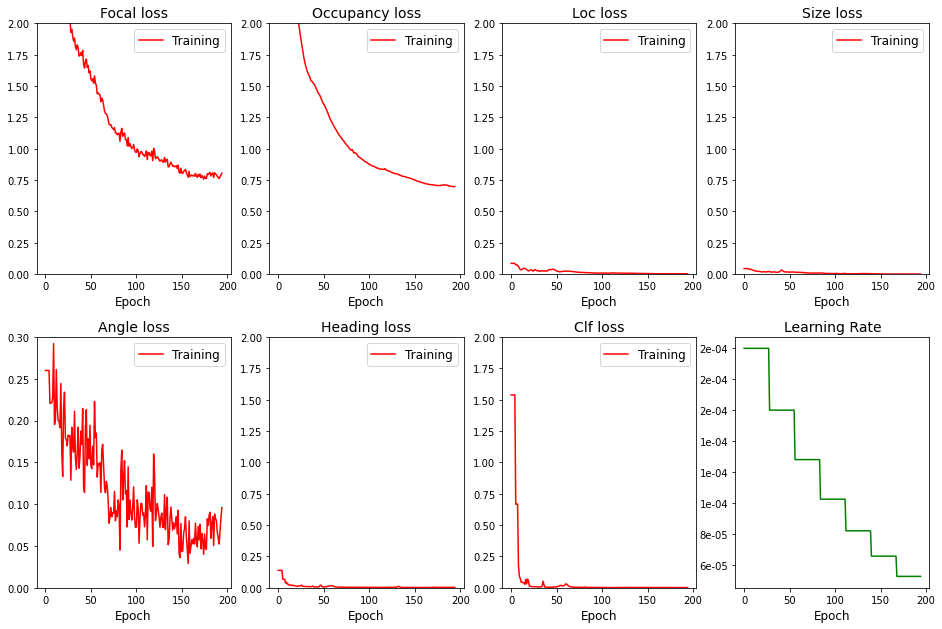

In [17]:
plot_history(results)

In [18]:
n_predictions = 4
eval_gen = SimpleDataGenerator(
    data_reader=data_reader, 
    batch_size=params.batch_size, 
    lidar_files=lidar_files[:n_predictions], 
    label_files=label_files[:n_predictions], 
    calibration_files=calibration_files[:n_predictions]
)

In [19]:
occupancy, position, size, angle, heading, classification = pillar_net.predict(
    eval_gen,
    batch_size=params.batch_size,
    verbose=1
)

1/1 [==============================] - 1s 758ms/step


In [20]:
set_boxes, confidences = [], []
loop_range = occupancy.shape[0] if len(occupancy.shape) == 4 else 1
for i in range(loop_range):
    bbox = generate_bboxes_from_pred(
        occupancy[i], 
        position[i], 
        size[i], 
        angle[i], 
        heading[i],
        classification[i], 
        params.anchor_dims, 
        occ_threshold=0.9
    )
    set_boxes.append(bbox)
    conf = [float(boxes.conf) for boxes in set_boxes[-1]]
    confidences.append(conf)
print('Scene 1: Box predictions with occupancy > occ_thr: ', len(set_boxes[0]))

Scene 1: Box predictions with occupancy > occ_thr:  78


In [21]:
# set_boxes[0:10]

In [22]:
# confidences[0:10]

In [23]:
# NMS
nms_boxes = rotational_nms(set_boxes, confidences, occ_threshold=0.7, nms_iou_thr=0.5)
print('Scene 1: Boxes after NMS with iou_thr: ', len(nms_boxes[0]))

# Do all the further operations on predicted_boxes array, which contains the predicted bounding boxes
gt_gen = GroundTruthGenerator(data_reader, label_files, calibration_files, network_format=False)
gt_gen0 = GroundTruthGenerator(data_reader, label_files, calibration_files, network_format=True)

Scene 1: Boxes after NMS with iou_thr:  77


In [24]:
for seq_boxes, gt_label, gt0 in zip(nms_boxes, gt_gen, gt_gen0):
    print("\n---------- New Scenario ---------- ")
    focal_loss_checker(gt0[0], occupancy[0], n_occs=-1)
    print("---------- ------------ ---------- ")
    for gt in gt_label:
        print(gt)
    for pred in seq_boxes:
        print(pred)


---------- New Scenario ---------- 
#matched gt:  0  #unmatched gt:  1  #unmatched pred:  1  occupancy threshold:  0.9924716
---------- ------------ ---------- 
GT | Cls: Pedestrian, x: 8.753024, y: -1.799722, l: 1.200000, w: 0.480000, yaw: -1.560796
BB | Cls: 2, x: 13.310185, y: -10.321095, l: 4.246984, w: 0.946585, yaw: 3.985088
BB | Cls: 3, x: 3.597884, y: -11.921200, l: 0.902420, w: 0.567420, yaw: -4.072538
BB | Cls: 1, x: 14.313657, y: 13.856969, l: 1.003841, w: 0.571995, yaw: -7.572279
BB | Cls: 2, x: 1.863574, y: 3.306313, l: 3.840166, w: 1.612526, yaw: 2.795633
BB | Cls: 2, x: 10.492227, y: -4.673514, l: 0.955677, w: 0.605360, yaw: 2.471851
BB | Cls: 1, x: 19.035273, y: 21.180448, l: 4.132140, w: 0.979750, yaw: -8.048095
BB | Cls: 0, x: 17.655771, y: -2.157492, l: 2.162624, w: 0.707786, yaw: -1.693617
BB | Cls: 3, x: 0.361280, y: 10.161823, l: 3.015833, w: 0.542986, yaw: -4.591431
BB | Cls: 2, x: 3.925973, y: 15.239001, l: 3.675148, w: 0.956108, yaw: 2.916202
BB | Cls: 1, x: 0

#matched gt:  0  #unmatched gt:  8  #unmatched pred:  8  occupancy threshold:  0.9711816
---------- ------------ ---------- 
GT | Cls: Car, x: 13.524518, y: -0.901202, l: 4.150000, w: 1.730000, yaw: 0.049204
BB | Cls: 0, x: 13.573770, y: -0.738323, l: 4.140956, w: 1.749477, yaw: -231.395721
BB | Cls: 1, x: 13.414438, y: -1.438191, l: 4.707797, w: 0.442427, yaw: -7.925699
BB | Cls: 3, x: 13.493319, y: -2.782524, l: 1.349143, w: 1.862978, yaw: -22.478372
BB | Cls: 0, x: 12.294617, y: 0.148778, l: 10.712128, w: 5.203744, yaw: -30.897383
BB | Cls: 2, x: 13.724034, y: 3.276103, l: 21.200854, w: 4.798562, yaw: -103.279510
BB | Cls: 0, x: 14.172340, y: 3.043326, l: 24.567028, w: 1.363940, yaw: -43.116528
BB | Cls: 3, x: 12.711599, y: -2.869192, l: 1.172719, w: 1.066276, yaw: 10.956431
BB | Cls: 0, x: 13.121763, y: -3.488294, l: 5.161521, w: 0.824048, yaw: 58.141418
BB | Cls: 3, x: 13.852456, y: -2.785585, l: 2.111034, w: 0.510652, yaw: -4.118699
BB | Cls: 0, x: 24.348002, y: -3.655026, l: 3.7